# Bennets Hipathia Script

## 1. Instalation & Setup

In [2]:
# --- Install 'dplyr' if missing ---
if (!requireNamespace("dplyr", quietly = TRUE)) {
    install.packages("dplyr")
}

# --- Install BiocManager if missing ---
if (!requireNamespace("BiocManager", quietly = TRUE)) {
    install.packages("BiocManager")
}

# --- Install or update 'hipathia' from Bioconductor ---
BiocManager::install("hipathia", ask = FALSE, update = TRUE)

# --- Load core libraries ---
library(dplyr)
library(hipathia)
library(data.table)

# --- Check installed versions (optional but useful for documentation) ---
packageVersion("hipathia")
packageVersion("dplyr")


'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.r-project.org

Bioconductor version 3.18 (BiocManager 1.30.27), R 4.3.3 (2024-02-29)

Warning message:
“package(s) not installed when version(s) same as or greater than current; use
  `force = TRUE` to re-install: 'hipathia'”
Old packages: 'igraph', 'textshaping', 'xml2'

Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘igraph’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages(update[instlib == l, "Package"], l, contriburl = contriburl, :
“installation of package ‘xml2’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.htm

[1] ‘3.2.0’

[1] ‘1.1.4’

## 2. Parameters

### 2.1 Set Paramter 

In [3]:
# ---- Input files ----
rna_path  <- "RNA_filtered_by_AIR.csv"        # raw RNA matrix: Genes × Cells
meta_path <- "complet_cell_metadata_grouped.csv"   # metadata with cell_id + celltype info

# ---- Output files ----
rna_standardized_out <- "rna_standardized.csv"
expr_pseudobulk_out  <- "expr_pseudobulk_symbols.csv"
design_out           <- "design.csv"

# Column in metadata that contains celltype annotation
group_column <- "celltype"
# ---- DEFINE GROUPS YOU WANT TO COMPARE ----
group1_name  <- "Normal"        # name in output (left in Hipathia)
group2_name  <- "Tumor"        # name in output (right in Hipathia)
# Which celltypes belong to each group?
group1_types <- c("Mesothelium")     # OR: c("CD4 T_cells")Mesothelium
group2_types <- c("Malignant")       # OR: c("CD8 T_cells")

# 2.3 Sample ID to inspect for celltype composition
inspect_sample <- "p4"

# Combined list of valid groups
allowed_groups <- c(group1_types, group2_types)

# ---- Options ----
pseudobulk_method <- "sum"
min_overlap_prop  <- 0.9
min_cells     <- 30

# ---- Hipathia ----
species       <- "hsa"
pathways_list <- c()   # empty = load all pathways





## 3. Patient Filtering

In [4]:
# Load metadata
meta <- read.csv(meta_path, stringsAsFactors = FALSE, check.names = FALSE)

# Ensure required columns exist
stopifnot(all(c("cell_id", "orig.ident", group_column) %in% colnames(meta)))

# Merge pXXXpos / pXXXneg → pXXX (patient-level)
meta$patient_id <- gsub("pos|neg", "", meta$orig.ident)

# Filter metadata to keep only the groups defined in the parameter block
meta_filt <- meta[meta[[group_column]] %in% c(group1_types, group2_types), ]

# Count cells per patient × group
cell_counts <- table(meta_filt$patient_id, meta_filt[[group_column]])

# Universal: sum counts for each group1/group2 type (in case multiple celltypes belong to a group)
group1_counts <- rowSums(cell_counts[, group1_types, drop = FALSE])
group2_counts <- rowSums(cell_counts[, group2_types, drop = FALSE])

# Which patients have enough cells from BOTH groups?
valid_patients <- names(which(group1_counts >= min_cells & group2_counts >= min_cells))


# ============================================
# BUILD GROUPED PATIENT × CELLTYPE TABLE
# ============================================

patients <- rownames(cell_counts)

# Reihen in der richtigen Reihenfolge
rows <- c(
  paste0('group1_name = "', group1_name, '"'),
  group1_types,
  paste0('group2_name = "', group2_name, '"'),
  group2_types,
  "keep"
)

# Matrix erstellen
diagnosis_matrix <- matrix(
  "",
  nrow = length(rows),
  ncol = length(patients),
  dimnames = list(rows, patients)
)

# Summen für group1
for (p in patients) {
  diagnosis_matrix[paste0('group1_name = "', group1_name, '"'), p] <-
    sum(cell_counts[p, group1_types], na.rm = TRUE)
}

# Summen für group2
for (p in patients) {
  diagnosis_matrix[paste0('group2_name = "', group2_name, '"'), p] <-
    sum(cell_counts[p, group2_types], na.rm = TRUE)
}

# Einzelne Celltypes einfügen
for (ct in group1_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}
for (ct in group2_types) {
  diagnosis_matrix[ct, ] <- as.character(cell_counts[, ct])
}

# keep-Zeile
diagnosis_matrix["keep", ] <- ifelse(
  group1_counts >= min_cells & group2_counts >= min_cells,
  "TRUE",
  "FALSE"
)


# In data.frame konvertieren
diagnosis_table <- as.data.frame(diagnosis_matrix)


# Print diagnostic table
print(diagnosis_table)

cat("\n===== PATIENT FILTERING DONE =====\n")
cat("Comparison: ", group1_name, " vs ", group2_name, "\n", sep = "")
cat("Min cells per group required: ", min_cells, "\n", sep = "")
cat("Patients passing filter: ", paste(valid_patients, collapse = ", "), "\n\n", sep = "")

# Final metadata restricted to valid patients only
meta_final <- meta_filt[meta_filt$patient_id %in% valid_patients, ]

# Assign Normal/Tumor group to each cell based on its celltype
meta_final$group <- ifelse(
    meta_final[[group_column]] %in% group1_types,
    group1_name,
    group2_name
)

# After filtering patients: extract valid cell barcodes
filtered_barcodes <- unique(meta_final$cell_id)

if (length(filtered_barcodes) == 0) {
    stop("Patient filter produced zero remaining cell barcodes.")
}

message("Number of remaining barcodes after filtering: ", length(filtered_barcodes))



                         p11   p12  p13   p4    p7 p786    p8  p811  p826  p846
group1_name = "Normal"     0     0   32   58     0  286     0     0     0     0
Mesothelium                0     0   32   58     0  286     0     0     0     0
group2_name = "Tumor"   1021  1143  116  330  2280  174  5672 11618  4109    97
Malignant               1021  1143  116  330  2280  174  5672 11618  4109    97
keep                   FALSE FALSE TRUE TRUE FALSE TRUE FALSE FALSE FALSE FALSE
                        p848    p9
group1_name = "Normal"     0     0
Mesothelium                0     0
group2_name = "Tumor"   3551   207
Malignant               3551   207
keep                   FALSE FALSE

===== PATIENT FILTERING DONE =====
Comparison: Normal vs Tumor
Min cells per group required: 30
Patients passing filter: p13, p4, p786



Number of remaining barcodes after filtering: 996



## 4. RNA Reader & Standardisation

### 4.1 Helper functions

In [5]:

trim_all <- function(df) {
  names(df) <- trimws(names(df))
  for (i in seq_along(df)) {
    if (is.character(df[[i]]))
      df[[i]] <- trimws(df[[i]])
  }
  df
}

looks_gene_symbol <- function(v) {
  v <- trimws(as.character(v))
  non_na <- v[!is.na(v)]

  if (length(non_na) == 0) return(FALSE)

  return(
    mean(grepl("[A-Za-z]", non_na)) > 0.5 &&
    mean(nchar(non_na) < 20) > 0.95 &&
    mean(grepl("-", non_na)) < 0.5 &&
    mean(grepl("^\\d+$", non_na)) < 0.1
  )
}

looks_barcode <- function(x) {
  x <- trimws(as.character(x))
  grepl("^[ACGTN]+[-_][0-9]+$", x)
}

# ---- WICHTIG: Die neue fread-basierte read_tab Funktion ----
read_tab <- function(path) {
  fread(path, data.table = FALSE)
}


### 4.2. Read RNA File

In [6]:
rna_raw <- read_tab(rna_path)
rna_raw <- trim_all(rna_raw)

rna_ids <- colnames(rna_raw)
meta_ids <- meta$cell_id

cat("Meta cells:", length(meta_ids), "\n")
cat("RNA cells: ", length(rna_ids), "\n")

cat("Cells in metadata but NOT in RNA:", 
    sum(!(meta_ids %in% rna_ids)), "\n")

# Drop empty columns
empty_cols <- which(sapply(rna_raw, function(x) all(x == "" | is.na(x))))
if (length(empty_cols)) rna_raw <- rna_raw[, -empty_cols, drop = FALSE]

stopifnot(ncol(rna_raw) >= 2)

# Detect gene column (robust)
# 1. Check common gene column names first
gene_name_hits <- which(tolower(colnames(rna_raw)) %in% c("gene", "genes", "symbol", "geneid"))

if (length(gene_name_hits) == 1) {
    gene_col <- gene_name_hits
} else {
    # 2. Fallback: heuristic
    first_col <- rna_raw[[1]]
    if (looks_gene_symbol(head(first_col, 200))) {
        gene_col <- 1
    } else {
        gene_col <- which(sapply(rna_raw, function(col)
            looks_gene_symbol(head(col, 200))))[1]
    }
}

if (is.na(gene_col)) stop("Could not detect gene column.")

colnames(rna_raw)[gene_col] <- "Gene"


Meta cells: 84526 
RNA cells:  84527 
Cells in metadata but NOT in RNA: 0 


### 4.4. Standardization RNA Matrix

In [7]:
rna <- rna_raw

# Gene column
rna$Gene <- as.character(rna$Gene)

# Welche Barcodes dürfen bleiben?
rna_barcodes   <- setdiff(colnames(rna), "Gene")
keep_barcodes  <- intersect(rna_barcodes, filtered_barcodes)

message("Keeping ", length(keep_barcodes), " barcodes after patient filtering.")

# Relevante Spalten auswählen
rna <- rna[, c("Gene", keep_barcodes), drop = FALSE]

# Bessere Numeric-Erkennung:
# akzeptiert: 1, 1.5, 1e-5, 0E0, NA, "", " "
valid_numeric <- function(x) {
    x <- trimws(x)
    ok <- grepl("^[-+]?[0-9]*\\.?[0-9]+([eE][-+]?[0-9]+)?$", x) | x == "" | is.na(x)
    all(ok)
}

# Konvertiere Barcodes
for (bc in keep_barcodes) {
    if (!valid_numeric(rna[[bc]])) {
        stop("Column ", bc, " contains non-numeric entries. This should not happen in an RNA matrix.")
    }

    rna[[bc]] <- suppressWarnings(as.numeric(trimws(rna[[bc]])))
}

# Drop empty genes
rna$Gene <- trimws(rna$Gene)
rna <- rna[rna$Gene != "", , drop = FALSE]

# Collapse duplicate genes (WICHTIG: keine Sortierung + Barcodes bleiben korrekt)
if (anyDuplicated(rna$Gene)) {
    message("Duplicate genes detected → collapsing by sum.")

    # Aggregiere korrekt und erhalte Barcode-Namen
    rna <- aggregate(
        rna[, keep_barcodes, drop = FALSE],
        by = list(Gene = rna$Gene),
        FUN = sum
    )

    # Stellt sicher, dass Reihenfolge Gene, Barcode1, Barcode2,... bleibt
    rna <- rna[, c("Gene", keep_barcodes), drop = FALSE]
}

# Export
write.csv(rna, rna_standardized_out, row.names = FALSE)
message("Wrote standardized RNA: ", ncol(rna) - 1, " barcodes kept.")


Keeping 996 barcodes after patient filtering.

Wrote standardized RNA: 996 barcodes kept.



## 5. Check

### 5.1. Check: cells per patient X


In [8]:
# ---- Inspect patient cell composition ----

cat("\n===== Inspecting sample:", inspect_sample, "=====\n")

# Filter for selected patient
meta_inspect <- meta[meta$orig.ident == inspect_sample, ]

if (nrow(meta_inspect) == 0) {
    stop("No cells found for patient: ", inspect_sample)
}

# Unique cell types
unique_celltypes_inspect <- unique(meta_inspect[[group_column]])

cat("\nUnique cell types for patient", inspect_sample, ":\n")
print(unique_celltypes_inspect)

# Count per celltype
table_inspect <- table(meta_inspect[[group_column]])

cat("\nCell counts for patient", inspect_sample, ":\n")
print(table_inspect)

cat("\n===== End inspection for:", inspect_sample, "=====\n\n")



===== Inspecting sample: p4 =====

Unique cell types for patient p4 :
 [1] "TAMs"          "Malignant"     "Mono_CD16"     "CD8"          
 [5] "cDC2"          "KLRC1_NK"      "CD4"           "Mono_CD14"    
 [9] "B_cells"       "Fibroblasts"   "Mesothelium"   "TFH"          
[13] "FGFBP2_NK"     "pDC"           "Tregs"         "Plasma"       
[17] "cDC1"          "SmoothMuscle"  "NKlike_Tcells" "Mast"         
[21] "Vein"          "mregDC"        "PLVAP"        

Cell counts for patient p4 :

      B_cells           CD4           CD8          cDC1          cDC2 
           42           350           218            34           197 
    FGFBP2_NK   Fibroblasts      KLRC1_NK     Malignant          Mast 
           20           199           213           330             3 
  Mesothelium     Mono_CD14     Mono_CD16        mregDC NKlike_Tcells 
           58           495           109             2             4 
          pDC        Plasma         PLVAP  SmoothMuscle          TAMs 
   

### 5.2. Check: Barcode Overlap AFTER standardization

In [9]:


meta_ids <- meta_final$cell_id             # nur Patienten, die du behalten hast
rna_ids  <- setdiff(colnames(rna), "Gene") # alle Barcodes, die noch in RNA sind

overlap <- intersect(meta_ids, rna_ids)
prop <- length(overlap) / length(rna_ids)

cat("\n===== Barcode Overlap AFTER standardization =====\n")
cat("Remaining RNA barcodes:   ", length(rna_ids), "\n")
cat("Remaining meta barcodes:  ", length(meta_ids), "\n")
cat("Overlap:                  ", length(overlap),
    sprintf(" (%.1f%%)\n", 100 * prop))

if (prop < min_overlap_prop) {
    warning("Barcode overlap after filtering < ",
            100 * min_overlap_prop, "% — check filtering logic.")
}



===== Barcode Overlap AFTER standardization =====
Remaining RNA barcodes:    996 
Remaining meta barcodes:   996 
Overlap:                   996  (100.0%)


### 5.3. CHECK: Patient filter sanity

In [10]:
# ==============================
# CHECK: Patient filter sanity
# ==============================

message("\n===== PATIENT FILTER CHECK =====")

# 1) Anzahl der Barcodes
message("Barcodes after filtering: ", length(filtered_barcodes))

if (length(filtered_barcodes) == 0) {
    stop("ERROR: No barcodes kept after patient filtering.")
}

# 2) Prüfen ob Barcodes in der RNA-Datei existieren
barcode_cols_in_rna <- setdiff(colnames(rna_raw), "Gene")

missing_in_rna <- setdiff(filtered_barcodes, barcode_cols_in_rna)

if (length(missing_in_rna) > 0) {
    message("WARNING: ", length(missing_in_rna),
            " barcodes are in metadata but missing in the RNA matrix:")
    print(head(missing_in_rna))
} else {
    message("All filtered barcodes exist in the RNA matrix. ✔")
}

# 3) Prüfen ob RNA-Barcodes existieren, die NICHT gefiltert wurden
extra_in_rna <- setdiff(barcode_cols_in_rna, filtered_barcodes)
message("RNA barcodes not part of filtered patients: ", length(extra_in_rna))



===== PATIENT FILTER CHECK =====

Barcodes after filtering: 996

All filtered barcodes exist in the RNA matrix. ✔

RNA barcodes not part of filtered patients: 83530



In [11]:
# 1. Number of barcodes in the original RNA matrix
original_rna_barcodes <- setdiff(colnames(rna_raw), "Gene")
message("Original RNA barcodes: ", length(original_rna_barcodes))

# 2. Number of barcodes after metadata filtering
message("Filtered (kept) barcodes in metadata: ", length(filtered_barcodes))

# 3. How many barcodes match between RNA and metadata?
meta_barcodes <- meta_final$cell_id
message("Overlap (RNA ∩ metadata): ",
        length(intersect(original_rna_barcodes, meta_barcodes)))

# 4. Which RNA barcodes were NOT kept by the patient filter?
lost <- setdiff(original_rna_barcodes, filtered_barcodes)
message("RNA barcodes discarded by patient filter: ", length(lost))
if (length(lost) > 0) print(head(lost, 20))




Original RNA barcodes: 84526

Filtered (kept) barcodes in metadata: 996

Overlap (RNA ∩ metadata): 996

RNA barcodes discarded by patient filter: 83530



 [1] "p786pos_AAACCCAAGTTGGAAT-1" "p786pos_AAACCCACAAACACCT-1"
 [3] "p786pos_AAACCCATCCACATAG-1" "p786pos_AAACGAACACATACGT-1"
 [5] "p786pos_AAACGAACAGCTGGTC-1" "p786pos_AAACGAAGTGTGAGCA-1"
 [7] "p786pos_AAACGCTGTATCACGT-1" "p786pos_AAACGCTTCAGGGTAG-1"
 [9] "p786pos_AAAGAACAGTGCAGGT-1" "p786pos_AAAGGATGTCCCTGAG-1"
[11] "p786pos_AAAGGATTCTCTATGT-1" "p786pos_AAAGGATTCTTCCCAG-1"
[13] "p786pos_AAAGGGCCAAGCCCAC-1" "p786pos_AAAGGGCTCCCATACC-1"
[15] "p786pos_AAAGGTAAGCATGCAG-1" "p786pos_AAAGGTACAATGGCAG-1"
[17] "p786pos_AAAGGTACACTCGATA-1" "p786pos_AAAGGTAGTAGTGGCA-1"
[19] "p786pos_AAAGGTAGTGGAATGC-1" "p786pos_AAAGGTATCAGCAATC-1"


## 6. Pseudobulk 

In [12]:
message("\n===== BUILDING PSEUDOBULK (Patient × Group) =====")

# 1) Keep filtered barcodes that exist in RNA
barcode_cols <- intersect(colnames(rna), filtered_barcodes)

rna_sub <- rna[, c("Gene", barcode_cols), drop = FALSE]

# 2) Filter metadata
meta_sub <- meta_final[meta_final$cell_id %in% barcode_cols, ]

# 3) Assign groups
meta_sub$group <- ifelse(
    meta_sub[[group_column]] %in% group1_types,
    group1_name,
    group2_name
)

# 4) Build unique sample names: Patient + "_" + Group
meta_sub$sample_group <- paste0(meta_sub$patient_id, "_", meta_sub$group)

sample_groups <- unique(meta_sub$sample_group)

# 5) Build pseudobulk for each Patient×Group
pb_mat <- sapply(sample_groups, function(sg) {
    cells <- meta_sub$cell_id[meta_sub$sample_group == sg]
    r_sub <- rna_sub[, cells, drop = FALSE]
    rowSums(r_sub, na.rm = TRUE)
})

# 6) Construct final pseudobulk dataframe
expr_pseudobulk <- data.frame(
    Gene = rna_sub$Gene,
    pb_mat,
    check.names = FALSE
)

# 7) Build design table
design <- data.frame(
    sample_id = sample_groups,
    patient   = sapply(sample_groups, function(x) strsplit(x, "_")[[1]][1]),
    group     = sapply(sample_groups, function(x) strsplit(x, "_")[[1]][2])
)

# 8) Save
write.csv(expr_pseudobulk, expr_pseudobulk_out, row.names = FALSE)
write.csv(design, design_out, row.names = FALSE)

message("Pseudobulk written for ", length(sample_groups), " sample groups.")
                       table(meta_sub$patient_id, meta_sub$group)




===== BUILDING PSEUDOBULK (Patient × Group) =====

Pseudobulk written for 6 sample groups.



      
       Normal Tumor
  p13      32   116
  p4       58   330
  p786    286   174

## 7. Map Gene Symbols to Entrez IDs


In [13]:
# Install Bioconductor annotation package if missing
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

if (!requireNamespace("org.Hs.eg.db", quietly = TRUE))
    BiocManager::install("org.Hs.eg.db")

# Load library
library(org.Hs.eg.db)

# Read pseudobulk matrix (symbols)
expr_pb <- read.csv(expr_pseudobulk_out, stringsAsFactors = FALSE, check.names = FALSE)

# Check
if (!"Gene" %in% colnames(expr_pb)) stop("Expression file must contain column 'Gene'.")

# Map Gene Symbols -> Entrez IDs
gene_symbols <- expr_pb$Gene
entrez_ids <- mapIds(org.Hs.eg.db,
                     keys = gene_symbols,
                     column = "ENTREZID",
                     keytype = "SYMBOL",
                     multiVals = "first")

# Add Entrez IDs
expr_pb$EntrezID <- entrez_ids

# Remove genes without mapping
expr_pb <- expr_pb[!is.na(expr_pb$EntrezID), ]

# Collapse duplicates (mean per EntrezID)
expr_pb <- aggregate(. ~ EntrezID, data = expr_pb[, c("EntrezID", setdiff(colnames(expr_pb), c("Gene", "EntrezID")))],
                     FUN = function(x) if (is.numeric(x)) mean(as.numeric(x), na.rm = TRUE) else x[1])

# Use EntrezID as rownames
rownames(expr_pb) <- expr_pb$EntrezID

# Remove redundant column
expr_pb$EntrezID <- NULL

# Save clean expression matrix
write.csv(expr_pb, "expr_pseudobulk_entrez.csv", row.names = TRUE)

# Report
cat("\n===== MAPPING DONE (fixed root version) =====\n")
cat("Input genes (symbols): ", length(gene_symbols), "\n", sep = "")
cat("Mapped to Entrez IDs : ", nrow(expr_pb), "\n", sep = "")
cat("File written: expr_pseudobulk_entrez.csv\n")




Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:dplyr’:

    select


'select()' returned 1:many mapping between keys and columns




===== MAPPING DONE (fixed root version) =====
Input genes (symbols): 1178
Mapped to Entrez IDs : 1172
File written: expr_pseudobulk_entrez.csv


## 8. Preprocessment

### 8.1. Gene IDs translation

In [14]:
#3.1
library(hipathia)

trans_data <- as.matrix(read.csv("expr_pseudobulk_entrez.csv",
                                 row.names = 1, check.names = FALSE))



### 8.2. Data scaling & normalization

In [15]:
#3.2
# exakt der Vignetten-Schritt:
exp_data <- normalize_data(trans_data, by_quantiles = FALSE)

write.csv(data.frame(Gene=rownames(exp_data), exp_data, check.names=FALSE),
          "Vinette_Like_RNA-Data.csv", row.names=FALSE)


Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.



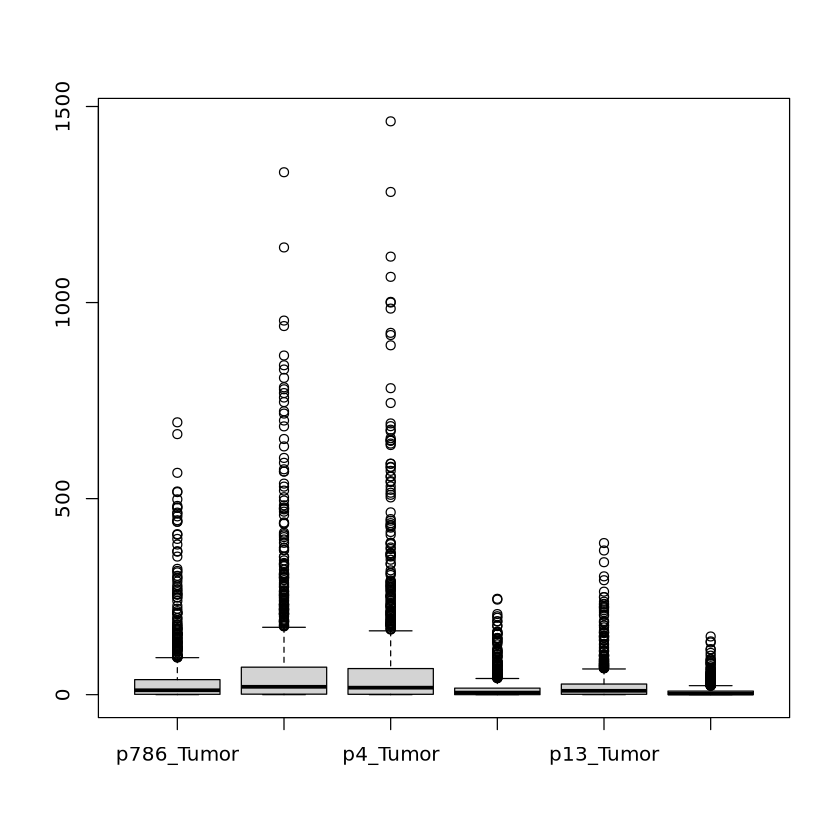

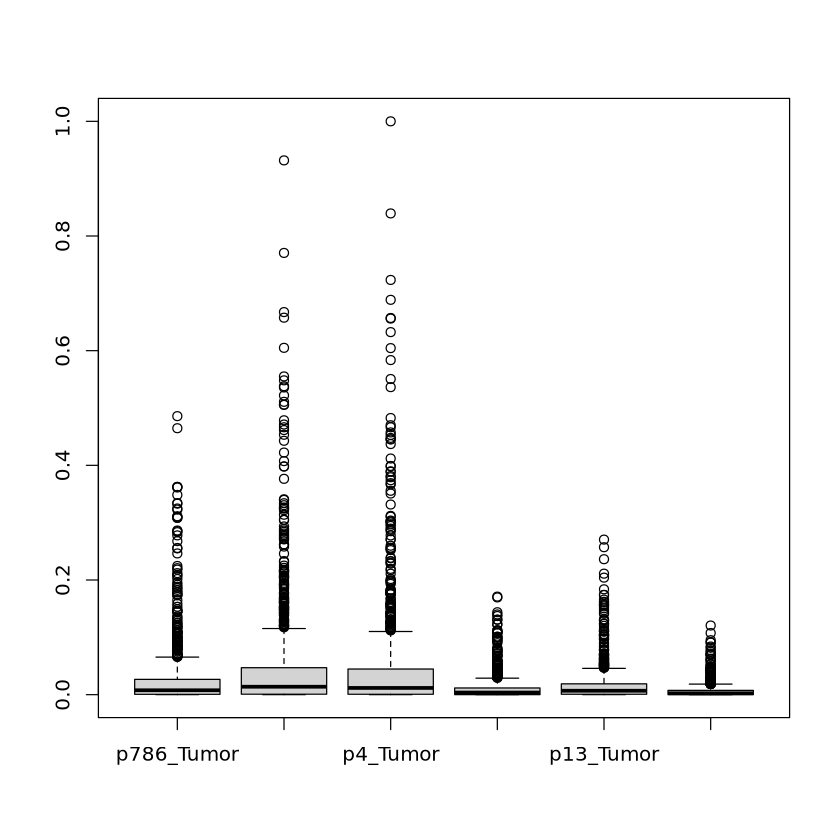

In [16]:
# vor Scaling
boxplot(trans_data)

# Limit threads (verhindert pthread-Fehler auf Clustern)
Sys.setenv(OMP_NUM_THREADS="1", MKL_NUM_THREADS="1",
           OPENBLAS_NUM_THREADS="1", VECLIB_MAXIMUM_THREADS="1")

# Versuche Quantile-Norm, sonst nimm Truncation wie in der Vignette
exp_data <- tryCatch(
  normalize_data(trans_data, by_quantiles = TRUE),
  error = function(e) {
    message("Quantile normalization failed (preprocessCore). Using truncation_percentil = 0.95.")
    normalize_data(trans_data, truncation_percentil = 0.95)
  }
)

boxplot(exp_data)


## 9. Pathaway activation computation

### 9.1. Download Pathaways

In [17]:
#4.1
if (length(pathways_list) == 0) {
    message("No pathway list provided -> loading ALL pathways for ", species)
    pathways <- load_pathways(species = species)
} else {
    message("Loading subset of pathways: ", paste(pathways_list, collapse = ", "))
    pathways <- load_pathways(species = species, pathways_list = pathways_list)
}

# ---- Check
length(pathways)   # Anzahl geladener Pathways
names(pathways)[1:5]  # Erste 5 Pathways anzeigen
get_pathways_list(pathways)[1:10]

No pathway list provided -> loading ALL pathways for hsa

Loaded 146 pathways



[1] 7

[1] "species"     "all.genes"   "path.norm"   "eff.norm"    "pathigraphs"

[1] "hsa03320" "hsa03460" "hsa04010" "hsa04012" "hsa04014" "hsa04015"
 [7] "hsa04020" "hsa04022" "hsa04024" "hsa04062"

### 9.2. Compute the signal

In [18]:
#4.3 Using Hipathia to comute the signal
results <- hipathia(exp_data, pathways, decompose = FALSE, verbose=FALSE)
## Added missing genes: 165 (4.93%)

Added missing genes: 2575 (68.72%)



In [19]:
#4.3 Using Hipathia to comute the signal
results

A MultiAssayExperiment object of 2 listed
 experiments with user-defined names and respective classes.
 Containing an ExperimentList class object of length 2:
 [1] nodes: SummarizedExperiment with 6826 rows and 6 columns
 [2] paths: SummarizedExperiment with 1876 rows and 6 columns
Functionality:
 experiments() - obtain the ExperimentList instance
 colData() - the primary/phenotype DataFrame
 sampleMap() - the sample coordination DataFrame
 `$`, `[`, `[[` - extract colData columns, subset, or experiment
 *Format() - convert into a long or wide DataFrame
 assays() - convert ExperimentList to a SimpleList of matrices
 exportClass() - save data to flat files

In [20]:
#4.3 Using Hipathia to comute the signal
path_vals <- get_paths_data(results)
hhead(path_vals, 4)

,p786_Tumor,p786_Normal,p4_Tumor,p4_Normal,p13_Tumor,p13_Normal
P-hsa03320-37,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
P-hsa03320-61,2.088801e-05,3.480413e-05,3.480413e-05,2.627657e-05,3.480413e-05,1.626034e-05
P-hsa03320-46,2.088801e-05,3.480413e-05,3.480413e-05,2.627657e-05,3.480413e-05,1.626034e-05
P-hsa03320-57,2.088801e-05,3.480413e-05,3.480413e-05,2.627657e-05,3.480413e-05,1.626034e-05


## 10. Function activation computation

In [21]:
#5 Function activation computation
uniprot_vals <- quantify_terms(results, pathways, dbannot = "uniprot")

go_vals <- quantify_terms(results, pathways, dbannot = "GO")
#142/1654 soll so sein

Quantified Uniprot terms: 142

Quantified GO terms: 1654



## 11. Pathway/Function activation analysis

In [22]:
sample_ids  <- colnames(path_vals)

design <- data.frame(
    sample = sample_ids,
    patient = sub("_(Tumor|Normal)$", "", sample_ids),
    group = sub("^.*_(Tumor|Normal)$", "\\1", sample_ids),
    row.names = sample_ids,
    stringsAsFactors = FALSE
)

sample_group <- design$group
names(sample_group) <- design$sample

comp <- do_wilcoxon(
    path_vals,
    sample_group,
    g1 = group1_name,
    g2 = group2_name
)

In [23]:
# -------------------------------------------------------
# 1) Sample-Namen aus path_vals holen
# -------------------------------------------------------
sample_ids <- colnames(path_vals)

# -------------------------------------------------------
# 2) Design-Tabelle automatisch erzeugen
#    Erwartetes Format der Spaltennamen:
#        p786_Tumor   → patient = "p786", group="Tumor"
#        p4_Normal    → patient = "p4",   group="Normal"
# -------------------------------------------------------
design <- data.frame(
    sample  = sample_ids,
    patient = sub("_(.*)$", "", sample_ids),
    group   = sub("^.*_", "", sample_ids),
    row.names = sample_ids,
    stringsAsFactors = FALSE
)

# -------------------------------------------------------
# 3) Sample-Gruppe als benannten Vektor
# -------------------------------------------------------
sample_group <- design$group
names(sample_group) <- design$sample

# -------------------------------------------------------
# 4) Wilcoxon-Test – VOLLSTÄNDIG dynamisch
# -------------------------------------------------------
comp <- do_wilcoxon(
    path_vals,
    sample_group,
    g1 = group1_name,
    g2 = group2_name
)

# Ausgabe prüfen
head(comp)


,UP/DOWN,statistic,p.value,FDRp.value
,<chr>,<dbl>,<dbl>,<dbl>
P-hsa03320-37,DOWN,-1.9639610,1.0000000,1
P-hsa03320-61,DOWN,-0.6546537,0.6428348,1
P-hsa03320-46,DOWN,-0.6546537,0.6428348,1
P-hsa03320-57,DOWN,-0.6546537,0.6428348,1
P-hsa03320-64,DOWN,-0.6546537,0.6428348,1
P-hsa03320-47,DOWN,-0.6546537,0.6428348,1


In [24]:
#6.1  Two classes comparison
pathways_summary <- get_pathways_summary(comp, pathways)
head(pathways_summary, 4)

,id_pathways,num_total_paths,num_significant_paths,percent_significant_paths,num_up_paths,percent_up_paths,num_down_paths,percent_down_paths
,<chr>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>
PPAR signaling pathway,hsa03320,42,0,0,0,0,0,0
Fanconi anemia pathway,hsa03460,7,0,0,0,0,0,0
MAPK signaling pathway,hsa04010,28,0,0,0,0,0,0
ErbB signaling pathway,hsa04012,18,0,0,0,0,0,0


In [25]:
#6.2 Pricipal Components ANalysis
ranked_path_vals <- path_vals[order(comp$p.value, decreasing = FALSE),]
pca_model <- do_pca(ranked_path_vals[1:ncol(ranked_path_vals),])

## 12. Heatmap

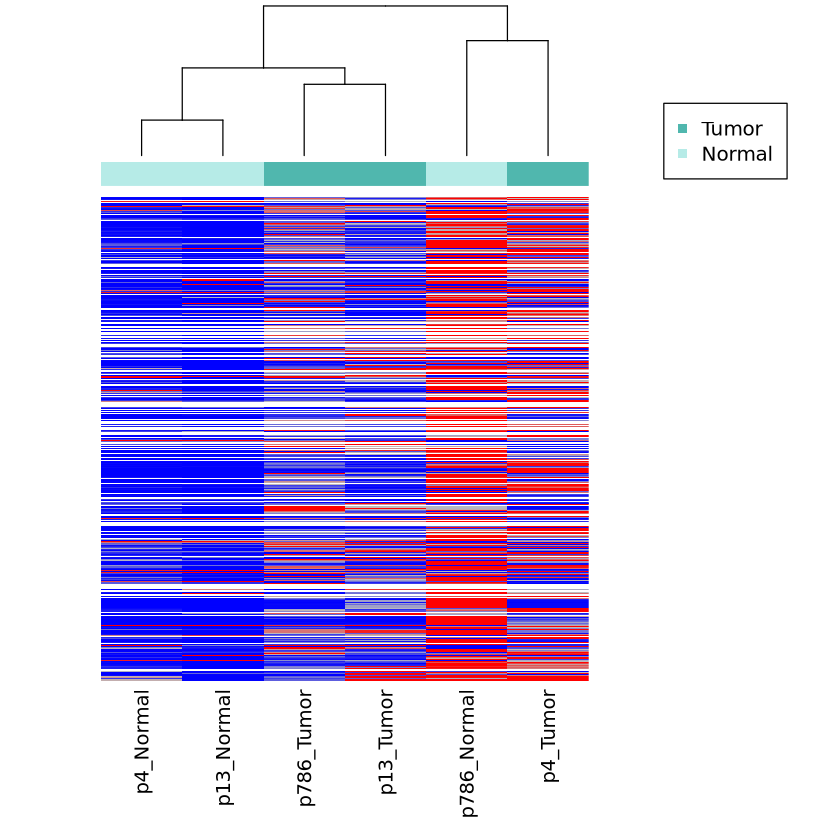

In [26]:
#7Heatmap
heatmap_plot(path_vals, group = sample_group)


In [27]:
# This should be TRUE; if FALSE, you sorted columns/rows inkonsistent
all(rownames(ranked_path_vals) %in% rownames(path_vals))
all(rownames(ranked_path_vals)[1:5] == rownames(comp)[order(comp$p.value, decreasing=FALSE, na.last=NA)][1:5])


[1] TRUE

[1] TRUE

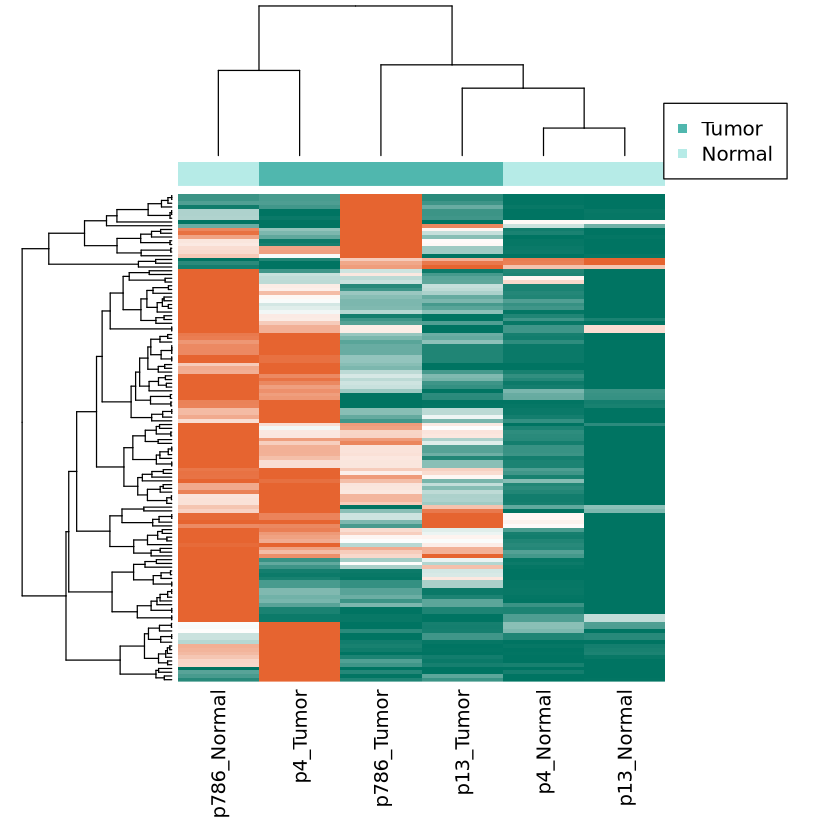

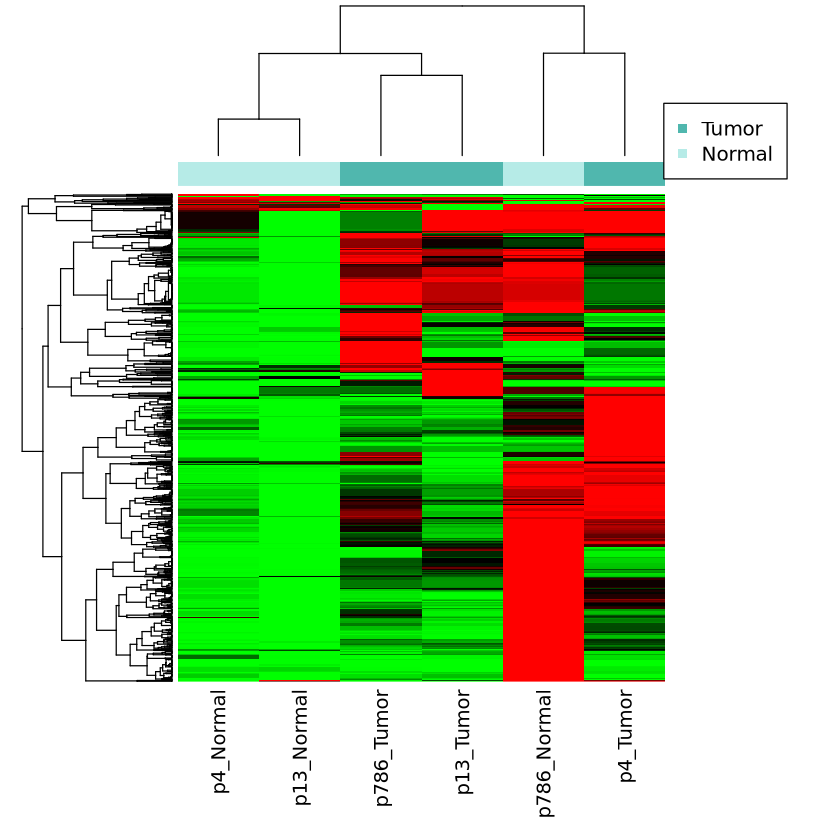

In [28]:
heatmap_plot(uniprot_vals, group = sample_group, colors="hipathia",
variable_clust = TRUE)
heatmap_plot(go_vals, group = sample_group, colors="redgreen",
variable_clust = TRUE)

In [29]:
ncol(uniprot_vals)
length(sample_group)

colnames(uniprot_vals)
names(sample_group)


[1] 6

[1] 6

[1] "p786_Tumor"  "p786_Normal" "p4_Tumor"    "p4_Normal"   "p13_Tumor"  
[6] "p13_Normal"

[1] "p786_Tumor"  "p786_Normal" "p4_Tumor"    "p4_Normal"   "p13_Tumor"  
[6] "p13_Normal"

## 13. PCA

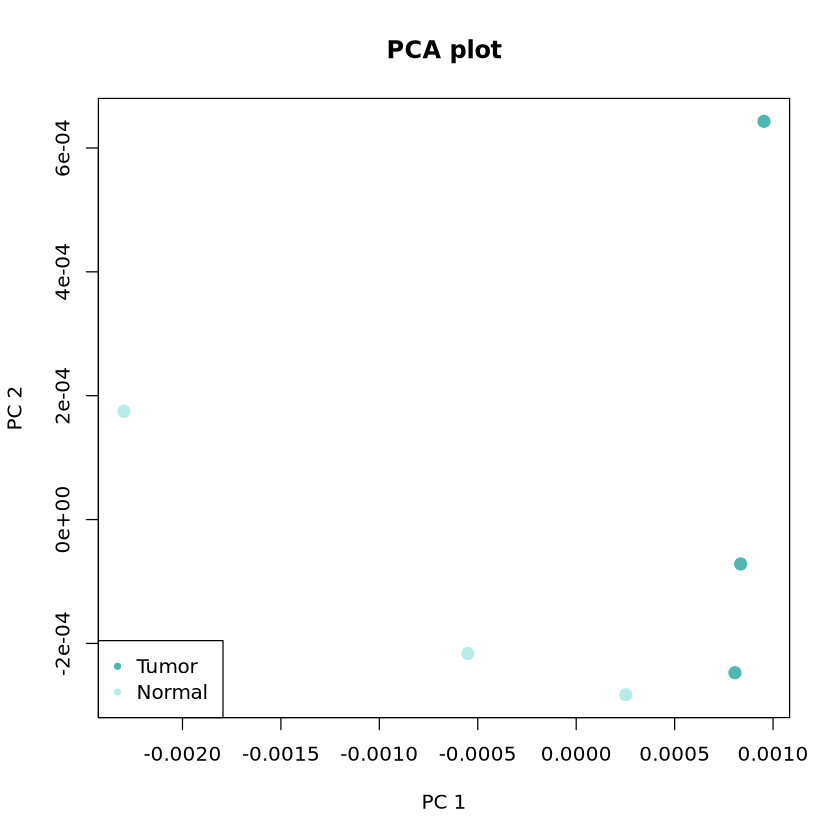

In [30]:
pca_plot(pca_model, sample_group, legend = TRUE)

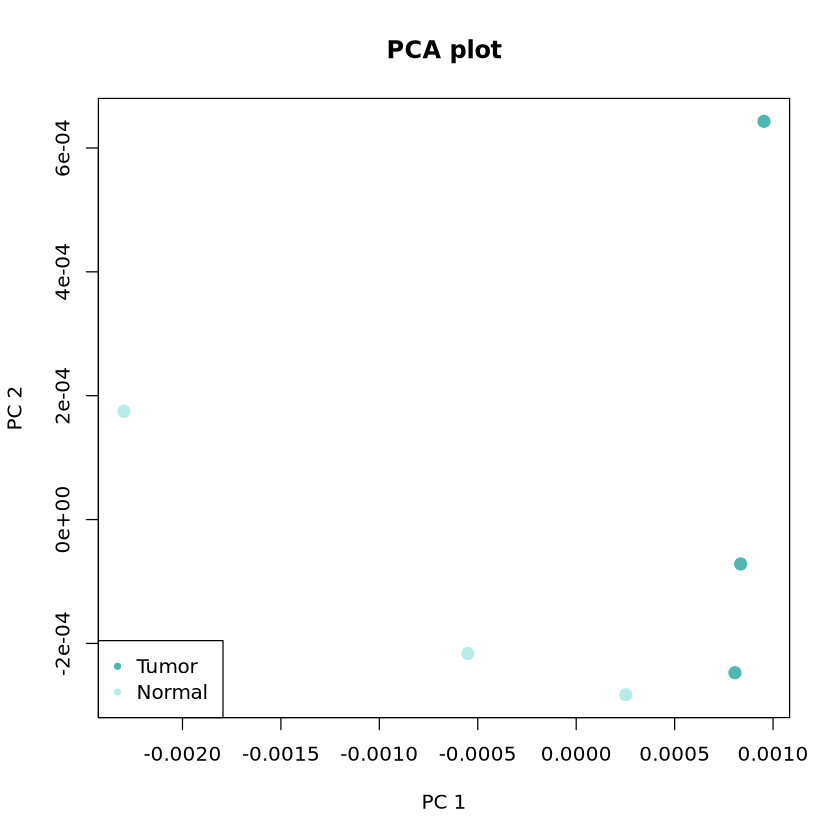

In [31]:
pca_plot(pca_model, sample_group, legend = TRUE)

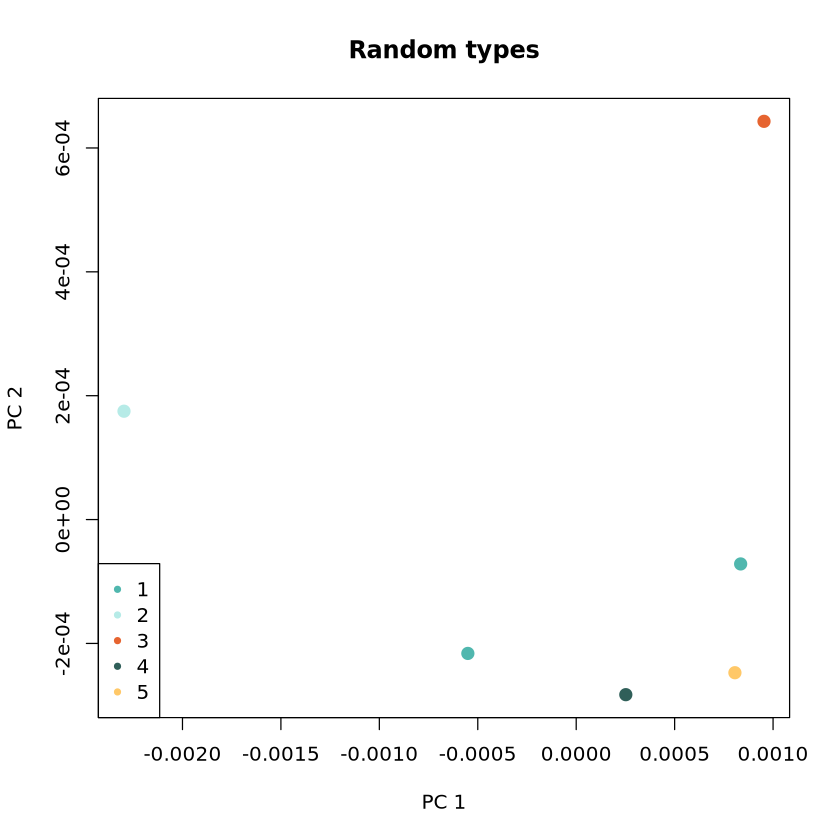

In [32]:

pca_plot(pca_model, group = rep(1:5, 8), main = "Random types",
legend = TRUE)

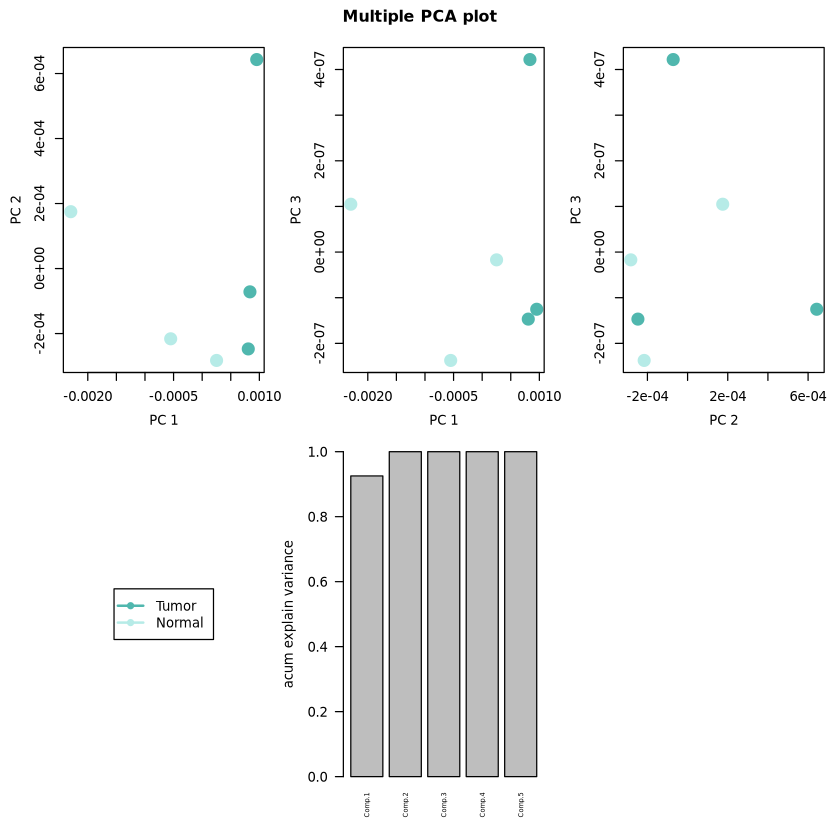

In [33]:
multiple_pca_plot(pca_model, sample_group, cex=3, plot_variance = TRUE)

## 14. Pathway_comparison

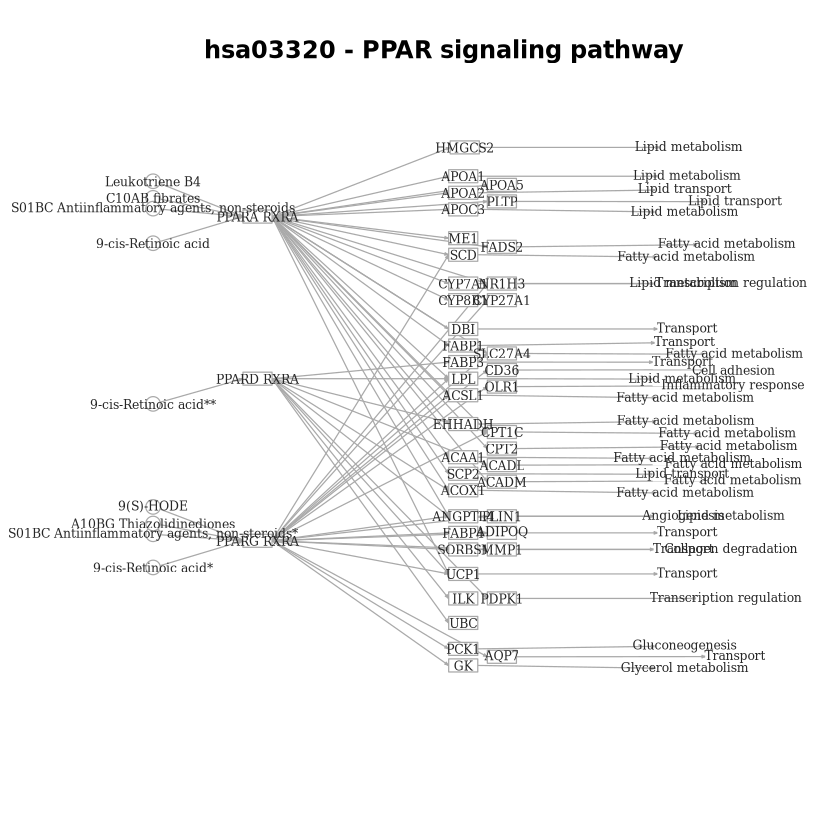

In [34]:
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320")

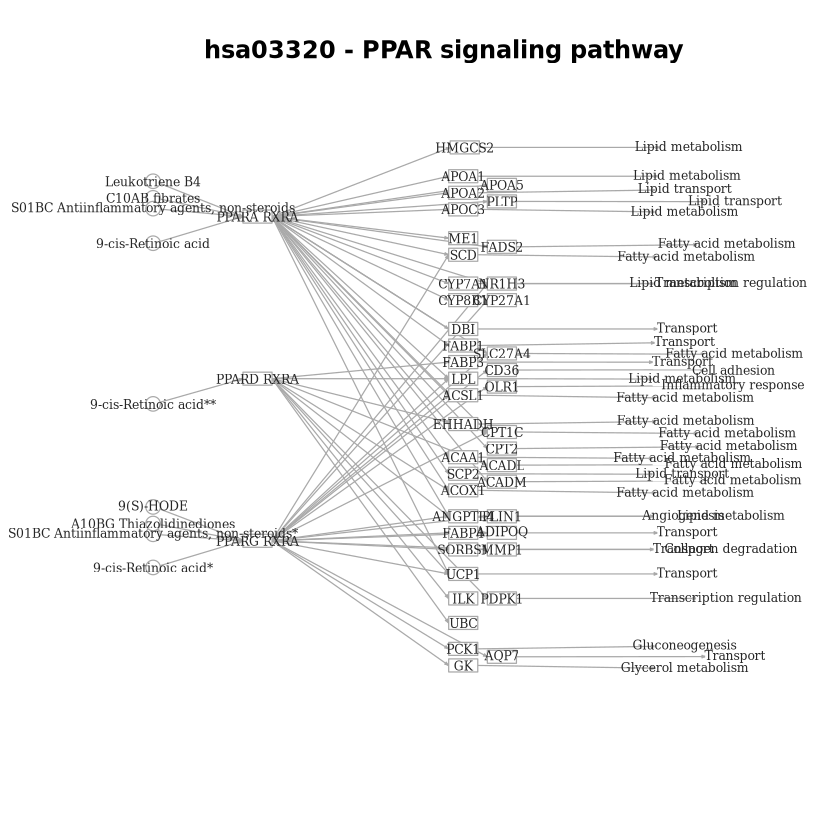

In [35]:
colors_de <- node_color_per_de(results, pathways, sample_group, "Tumor",
"Normal")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de)

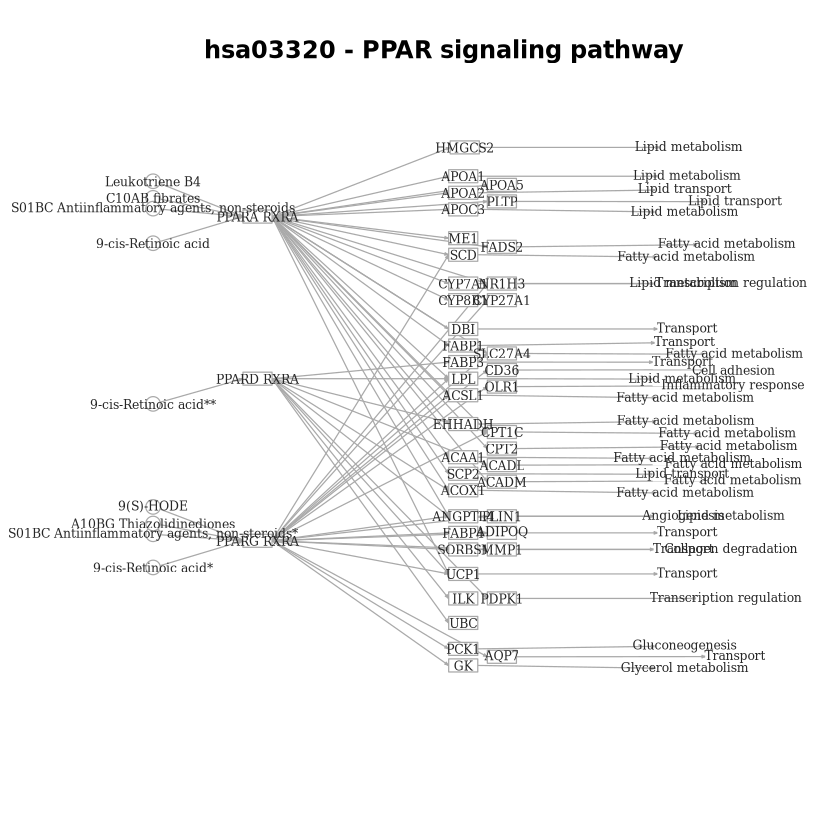

In [36]:
colors_de_hipathia <- node_color_per_de(results, pathways, sample_group,
"Tumor", "Normal", colors = "hipathia")
pathway_comparison_plot(comp, metaginfo = pathways, pathway = "hsa03320",
node_colors = colors_de_hipathia, colors = "hipathia")
pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = colors_de_hipathia,
  colors = "hipathia",
)

In [37]:
#7.4. Vizualization through a local server
report <- create_report(comp, pathways, "save_noColors")
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...
#report_colors <- create_report(comp, pathways, "save_colors",
#node_colors = colors_de)
## Creating report folders...
## Creating pathways folder...
## Creating HTML index...


Creating report folders...

Creating pathways folder...

Creating HTML index...



In [38]:

visualize_report(report, port = 4002)

Serving the directory /tmp/RtmpZDPcQ3/save_noColors/pathway-viewer at http://127.0.0.1:4002



Open a web browser and go to URL http://127.0.0.1:4002


In [39]:
# 1) alte servr-Prozesse beenden
if (requireNamespace("servr", quietly = TRUE)) {
  dl <- try(servr::daemon_list(), silent = TRUE)
  if (!inherits(dl, "try-error") && NROW(dl)) {
    for (i in dl$id) try(servr::daemon_stop(i), silent = TRUE)
  }
}

# 2) freien Port wählen
port <- servr::random_port()  # nimmt garantiert freien Port, z.B. 4010

# 3) Report visualisieren
visualize_report(report, port = port)


Serving the directory /tmp/RtmpZDPcQ3/save_noColors/pathway-viewer at http://127.0.0.1:4321



Open a web browser and go to URL http://127.0.0.1:4321


In [40]:
apply(trans_data, 2, sd)


p786_Tumor p786_Normal    p4_Tumor   p4_Normal   p13_Tumor  p13_Normal 
   78.35288   137.63507   147.46431    29.46263    41.99464    15.34400

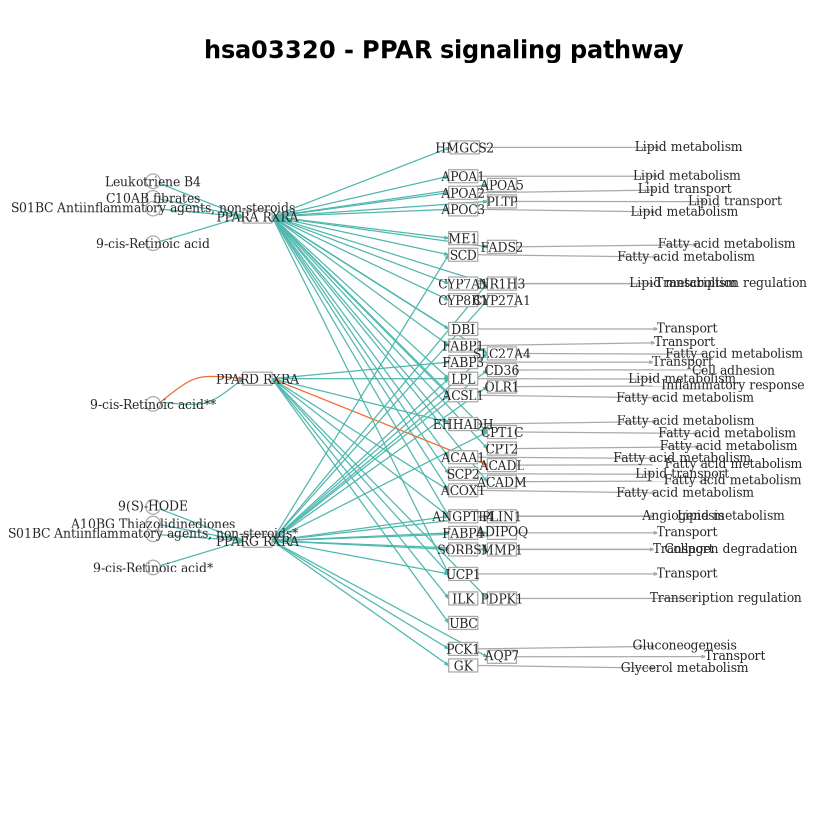

In [41]:
comp$FDRp.value <- runif(nrow(comp), 0, 0.01)  # zufällige kleine Werte
comp$UP.DOWN <- sample(c("UP","DOWN"), nrow(comp), replace = TRUE)

pathway_comparison_plot(
  comp,
  metaginfo = pathways,
  pathway = "hsa03320",
  node_colors = node_color_per_de(results, pathways, sample_group,
                                  "Tumor", "Normal", colors = "hipathia"),
  colors = "hipathia"
)


In [42]:
apply(trans_data, 2, sd)


p786_Tumor p786_Normal    p4_Tumor   p4_Normal   p13_Tumor  p13_Normal 
   78.35288   137.63507   147.46431    29.46263    41.99464    15.34400

In [43]:
table(design$group)



Normal  Tumor 
     3      3 

In [44]:
table(meta$group, meta$orig.ident)


        
           p10   p11   p12   p13    p4    p7 p786neg p786pos  p811  p826  p846
  Normal  4625  2636  1463  4700  7205  6596    5173    3387  3959   419  1362
  Tumor      0  1021  1143   116   330  2280     171       3 11618  4109    97
        
          p848 p8neg p8pos    p9
  Normal  3940    17   442  8284
  Tumor   3551  3427  2245   207